In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816190644.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816191719.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816184716.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816184836.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816181247.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816190707.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816184311.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816191139.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816190710.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816190058.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816181426.jpg
/kaggle/input/cnn-model1/dataset/Leaf that uses to make tea/IMG20230816183137.jpg
/kaggle/input/cn

In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# --- Configuration ---
DATA_DIR = "/kaggle/input/cnn-model1/dataset"  
OUTPUT_DIR = "/kaggle/working"
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.0005

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [4]:
# --- Transforms ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # [NEW] Color Jitter added to prevent overfitting
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# --- Load Dataset ---
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

# --- Split Dataset ---
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])

# Apply transforms
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Classes: ['Leaf that not to be used to make tea', 'Leaf that uses to make tea']
Train: 522, Val: 149, Test: 76


In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv1(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        result = out * self.sa(out)
        return result

In [7]:
class AttentionCNN(nn.Module):
    def __init__(self, num_classes):
        super(AttentionCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        self.cbam1 = CBAM(32)

        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam2 = CBAM(64)

        # Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam3 = CBAM(128)

        # Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam4 = CBAM(256)

        # Block 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam5 = CBAM(512)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            # [CHANGED] Increased Dropout to 0.6
            nn.Dropout(0.6), 
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.cbam1(self.conv1(x))
        x = self.cbam2(self.conv2(x))
        x = self.cbam3(self.conv3(x))
        x = self.cbam4(self.conv4(x))
        x = self.cbam5(self.conv5(x))
        x = self.classifier(x)
        return x

model = AttentionCNN(num_classes).to(device)

In [8]:
# [CHANGED] Added weight_decay=1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("\nStarting Training...")
best_val_loss = float("inf")
train_losses, val_losses = [], []
patience = 3
wait = 0

start_train_time = time.time()

for epoch in range(EPOCHS):
    # Train
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss_sum, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    
    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_att_model.pth"))
        print(" ** Saved Best Model **")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered!")
            break

print(f"\nTotal Training Duration: {time.time() - start_train_time:.2f} seconds")


Starting Training...


Epoch 1/5: 100%|██████████| 17/17 [02:29<00:00,  8.79s/it]


 Train Loss: 0.3754 | Train Acc: 0.8295
 Val Loss  : 1.4906 | Val Acc  : 0.4362
 ** Saved Best Model **


Epoch 2/5: 100%|██████████| 17/17 [02:22<00:00,  8.37s/it]


 Train Loss: 0.1018 | Train Acc: 0.9693
 Val Loss  : 2.9562 | Val Acc  : 0.4362


Epoch 3/5: 100%|██████████| 17/17 [02:23<00:00,  8.43s/it]


 Train Loss: 0.1738 | Train Acc: 0.9464
 Val Loss  : 2.0095 | Val Acc  : 0.6376


Epoch 4/5: 100%|██████████| 17/17 [02:22<00:00,  8.39s/it]


 Train Loss: 0.1269 | Train Acc: 0.9444
 Val Loss  : 0.2327 | Val Acc  : 0.9128
 ** Saved Best Model **


Epoch 5/5: 100%|██████████| 17/17 [02:22<00:00,  8.38s/it]


 Train Loss: 0.0636 | Train Acc: 0.9713
 Val Loss  : 0.3953 | Val Acc  : 0.8926

Total Training Duration: 866.46 seconds


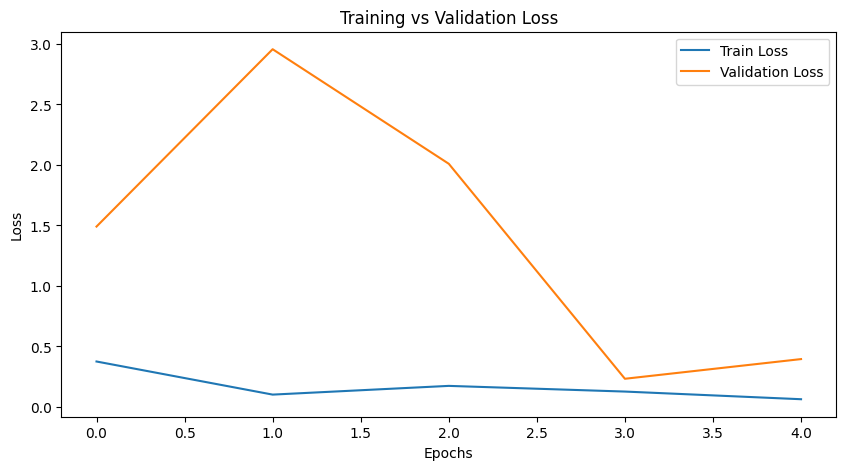

In [9]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Testing Duration: 14.54 seconds

Classification Report:

                                      precision    recall  f1-score   support

Leaf that not to be used to make tea       1.00      0.93      0.96        40
          Leaf that uses to make tea       0.92      1.00      0.96        36

                            accuracy                           0.96        76
                           macro avg       0.96      0.96      0.96        76
                        weighted avg       0.96      0.96      0.96        76



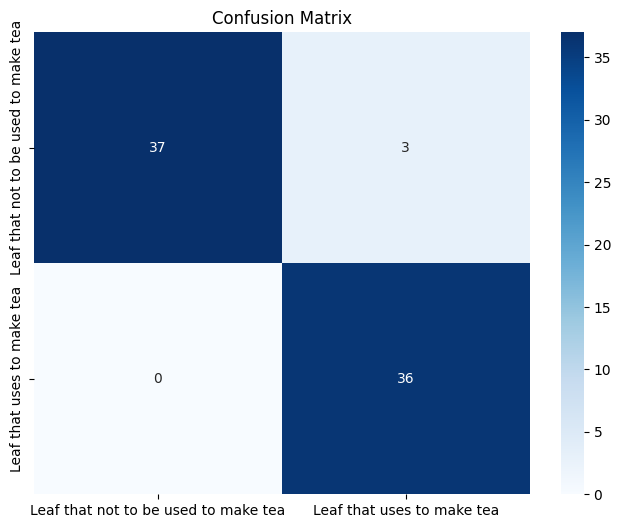

In [10]:
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_att_model.pth")))
model.eval()

y_true = []
y_pred = []
y_score = []

start_test_time = time.time()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

print(f"Testing Duration: {time.time() - start_test_time:.2f} seconds")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()

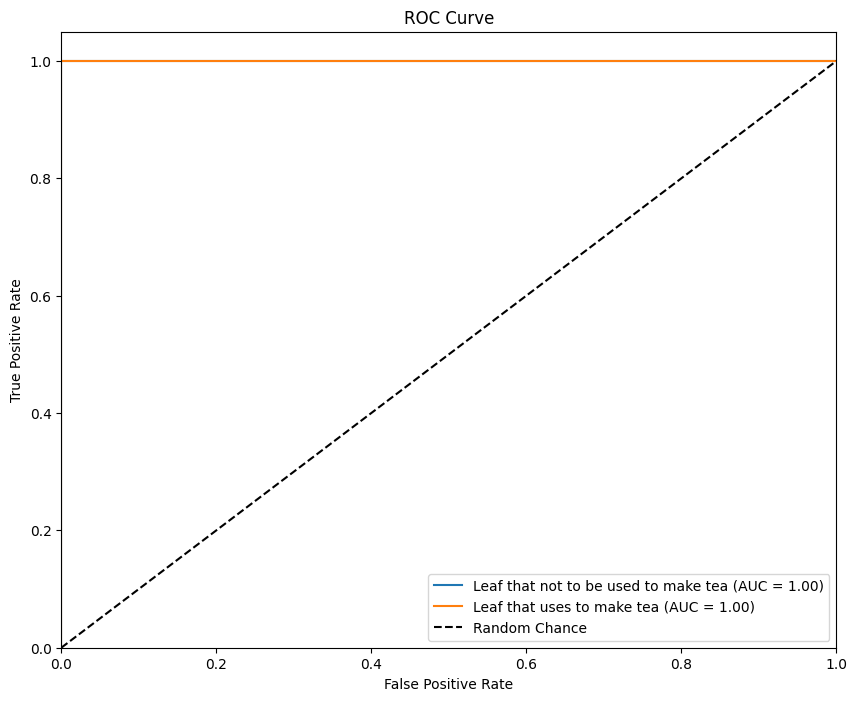

In [11]:

from sklearn.preprocessing import label_binarize


y_score = np.array(y_score)
y_true_bin = label_binarize(y_true, classes=range(num_classes))


if num_classes == 2:
    y_true_bin = np.hstack((1 - y_true_bin, y_true_bin))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()